In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F

from pynamical import bifurcation_plot, cubic_map, logistic_map, simulate, singer_map
from torch.utils.data import DataLoader, Dataset

np.set_printoptions(suppress=True)

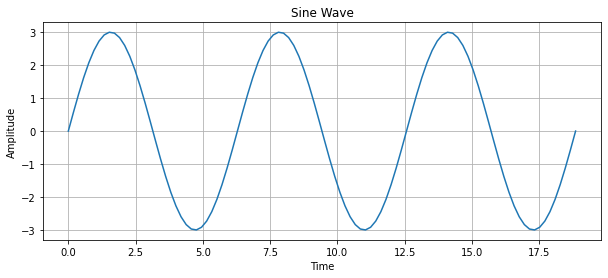

In [2]:
# generate a sine wave

frequency = 3 # number of oscillations
amplitude = 3 # peak height of wave
theta = 0 # amplitude of wave at time 0

x = np.linspace(0, 2*np.pi*frequency, 100)
y = amplitude * np.sin(x) + theta

def visualise_wave(x, y, label):  
    
    fig = plt.figure()
    fig.set_figwidth(10)
    plt.plot(x, y)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(label)
    plt.grid(True)
    plt.show()
    
visualise_wave(x, y, "Sine Wave")

sine_wave_data = y

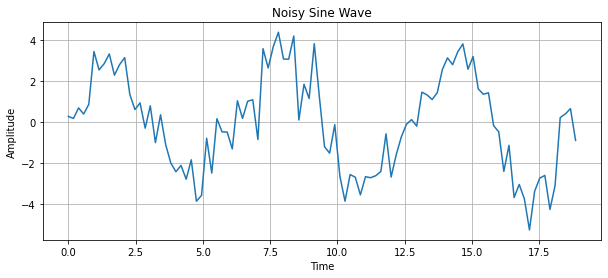

In [3]:
# add noise to sine wave

noise = np.random.normal(0,1,100)
y = y + noise

visualise_wave(x, y, "Noisy Sine Wave")

noisy_wave_data = y

In [4]:
# generate chaotic maps (functions that exhibit some sort of chaotic behavior)

logistic_map_data = simulate(model=logistic_map, num_gens=1, rate_min=0, rate_max=4, num_rates=100, num_discard=100)
singer_map_data = simulate(model=singer_map, num_gens=1, rate_min=0.9, rate_max=1.08, num_rates=100, num_discard=100)
cubic_map_data = simulate(model=cubic_map, num_gens=1, rate_min=1, rate_max=4, num_rates=100, num_discard=100)


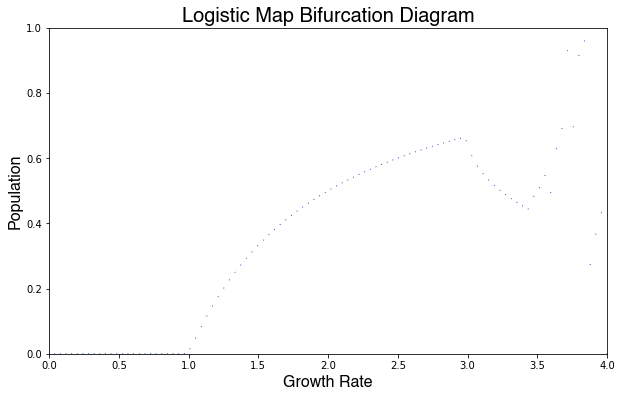

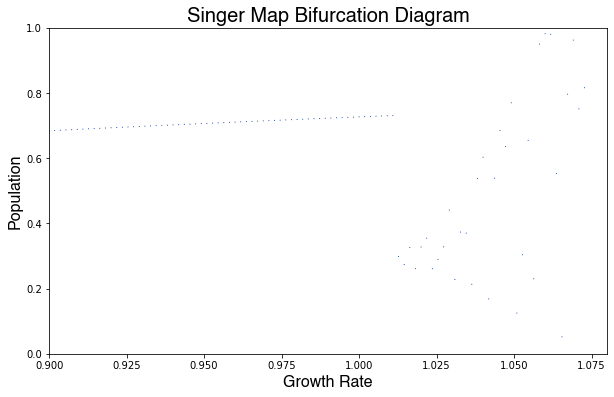

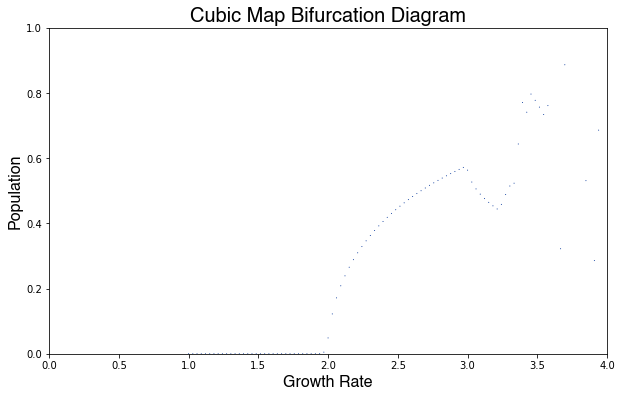

In [5]:
# visualisations of chaotic maps

bifurcation_plot(logistic_map_data, title="Logistic Map Bifurcation Diagram")
bifurcation_plot(singer_map_data, title="Singer Map Bifurcation Diagram", xmin=0.9, xmax=1.08, save=False)
bifurcation_plot(cubic_map_data, title="Cubic Map Bifurcation Diagram")

In [6]:
# split timeseries data into samples: predicting one point

def split_data(data, n):
    """
    n = number of samples in input
    inputs = [point 1, point 2, ..., point n]
    predictions = output i.e [point n+1]
    """
    inputs = []
    predictions = []
    for i in range(len(data)):  
        last_index = i + n
        if last_index > len(data) - 1:
            break # prevent "index is out of range" error
        inputs.append(data[i:last_index])
        predictions.append(data[last_index])
    return np.array(inputs), np.array(predictions)

In [7]:
# load the dataset

class timeseries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        """
        returns a sample from the dataset at the given index idx
        """
        return self.x[idx], self.y[idx]

In [8]:
class MLP(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):      
        out = self.l1(x)
        out = out[:,-1,:]
        out = self.relu(out)
        out = self.l2(out)
        return out

In [9]:
def predict_single_point(data, no_inputs):
    
    if type(data) != np.ndarray:
        print("Converting to numpy array")
        data = data.to_numpy().flatten()
        print("Successfully converted\n")
        
    print("Formatting data for prediction")
    inputs, predictions = split_data(data, no_inputs)
    print("Successfully formatted\n")
    
    print("Splitting into testing and training sets")
    x_train = inputs[:70]
    x_test = inputs[70:]
    y_train = predictions[:70]
    y_test = predictions[70:]
    print("Successfully split")
    
    print("Creating dataloaders")
    train_data = timeseries(x_train, y_train)
    test_data = timeseries(x_test, y_test)
    train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True) 
    test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
    print("Successfully created\n")
    
    print("Building the model")
    model = MLP(1, no_inputs, 1)
    print(model)
    print("\n")

    # optimizer , loss
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    epochs = 10000

    # training loop
    print("Beginning training")
    for i in range(epochs):
        for j,data in enumerate(train_dataloader):
            x = data[:][0].view(-1,no_inputs,1)
            y = data[:][1]
            y_pred = model(x).reshape(-1)
            loss = criterion(y_pred,y)
            loss.backward()
            optimizer.step()
        if i%1000 == 0:
            print(i,"th iteration : ",loss)
    print("Training done\n")
    
    print("Visualising actual signal vs predicted")
    test_pred = model(train_data[:][0].view(-1,no_inputs,1))
    plt.plot(test_pred.detach().numpy(),label='predicted')
    plt.plot(train_data[:][1],label='original')
    plt.legend()


Formatting data for prediction
Successfully formatted

Splitting into testing and training sets
Successfully split
Creating dataloaders
Successfully created

Building the model
MLP(
  (l1): Linear(in_features=1, out_features=5, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=5, out_features=1, bias=True)
)


Beginning training
0 th iteration :  tensor(5.1545, grad_fn=<MseLossBackward>)
1000 th iteration :  tensor(0.4030, grad_fn=<MseLossBackward>)
2000 th iteration :  tensor(0.7006, grad_fn=<MseLossBackward>)
3000 th iteration :  tensor(0.8974, grad_fn=<MseLossBackward>)
4000 th iteration :  tensor(1.9989, grad_fn=<MseLossBackward>)
5000 th iteration :  tensor(0.3114, grad_fn=<MseLossBackward>)
6000 th iteration :  tensor(0.3265, grad_fn=<MseLossBackward>)
7000 th iteration :  tensor(0.1402, grad_fn=<MseLossBackward>)
8000 th iteration :  tensor(0.7470, grad_fn=<MseLossBackward>)
9000 th iteration :  tensor(0.6184, grad_fn=<MseLossBackward>)
Training done

Visualising actual sig

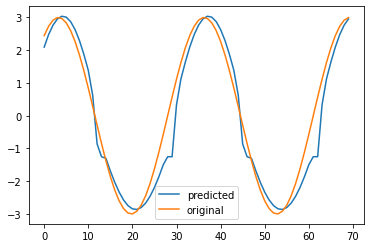

In [10]:
predict_single_point(sine_wave_data, 5)

Formatting data for prediction
Successfully formatted

Splitting into testing and training sets
Successfully split
Creating dataloaders
Successfully created

Building the model
MLP(
  (l1): Linear(in_features=1, out_features=6, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=6, out_features=1, bias=True)
)


Beginning training
0 th iteration :  tensor(11.3704, grad_fn=<MseLossBackward>)
1000 th iteration :  tensor(1.3031, grad_fn=<MseLossBackward>)
2000 th iteration :  tensor(5.2680, grad_fn=<MseLossBackward>)
3000 th iteration :  tensor(2.9020, grad_fn=<MseLossBackward>)
4000 th iteration :  tensor(0.2819, grad_fn=<MseLossBackward>)
5000 th iteration :  tensor(2.0246, grad_fn=<MseLossBackward>)
6000 th iteration :  tensor(1.6754, grad_fn=<MseLossBackward>)
7000 th iteration :  tensor(1.5358, grad_fn=<MseLossBackward>)
8000 th iteration :  tensor(1.8480, grad_fn=<MseLossBackward>)
9000 th iteration :  tensor(0.9444, grad_fn=<MseLossBackward>)
Training done

Visualising actual si

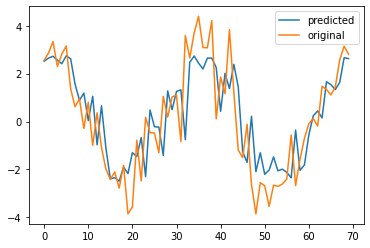

In [11]:
predict_single_point(noisy_wave_data, 6)

Converting to numpy array
Successfully converted

Formatting data for prediction
Successfully formatted

Splitting into testing and training sets
Successfully split
Creating dataloaders
Successfully created

Building the model
MLP(
  (l1): Linear(in_features=1, out_features=3, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=3, out_features=1, bias=True)
)


Beginning training
0 th iteration :  tensor(0.5195, grad_fn=<MseLossBackward>)
1000 th iteration :  tensor(0.0424, grad_fn=<MseLossBackward>)
2000 th iteration :  tensor(0.1739, grad_fn=<MseLossBackward>)
3000 th iteration :  tensor(0.0563, grad_fn=<MseLossBackward>)
4000 th iteration :  tensor(0.0816, grad_fn=<MseLossBackward>)
5000 th iteration :  tensor(0.0517, grad_fn=<MseLossBackward>)
6000 th iteration :  tensor(0.0223, grad_fn=<MseLossBackward>)
7000 th iteration :  tensor(0.0346, grad_fn=<MseLossBackward>)
8000 th iteration :  tensor(0.0117, grad_fn=<MseLossBackward>)
9000 th iteration :  tensor(0.0360, grad_fn=<MseLo

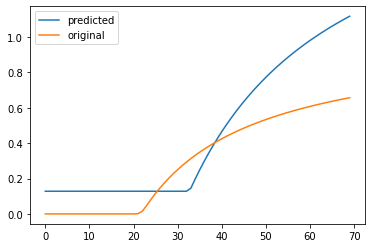

In [12]:
predict_single_point(logistic_map_data, 3)

Converting to numpy array
Successfully converted

Formatting data for prediction
Successfully formatted

Splitting into testing and training sets
Successfully split
Creating dataloaders
Successfully created

Building the model
MLP(
  (l1): Linear(in_features=1, out_features=8, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=8, out_features=1, bias=True)
)


Beginning training
0 th iteration :  tensor(0.5920, grad_fn=<MseLossBackward>)
1000 th iteration :  tensor(0.0065, grad_fn=<MseLossBackward>)
2000 th iteration :  tensor(0.2124, grad_fn=<MseLossBackward>)
3000 th iteration :  tensor(0.0126, grad_fn=<MseLossBackward>)
4000 th iteration :  tensor(0.1458, grad_fn=<MseLossBackward>)
5000 th iteration :  tensor(0.0124, grad_fn=<MseLossBackward>)
6000 th iteration :  tensor(0.0097, grad_fn=<MseLossBackward>)
7000 th iteration :  tensor(0.0452, grad_fn=<MseLossBackward>)
8000 th iteration :  tensor(0.0703, grad_fn=<MseLossBackward>)
9000 th iteration :  tensor(0.0101, grad_fn=<MseLo

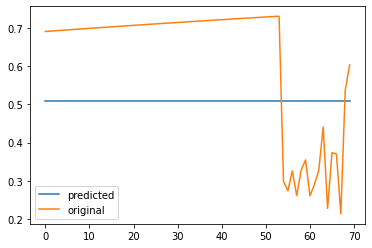

In [13]:
predict_single_point(singer_map_data, 8)

Converting to numpy array
Successfully converted

Formatting data for prediction
Successfully formatted

Splitting into testing and training sets
Successfully split
Creating dataloaders
Successfully created

Building the model
MLP(
  (l1): Linear(in_features=1, out_features=8, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=8, out_features=1, bias=True)
)


Beginning training
0 th iteration :  tensor(0.1312, grad_fn=<MseLossBackward>)
1000 th iteration :  tensor(0.0183, grad_fn=<MseLossBackward>)
2000 th iteration :  tensor(0.0010, grad_fn=<MseLossBackward>)
3000 th iteration :  tensor(0.0090, grad_fn=<MseLossBackward>)
4000 th iteration :  tensor(0.0078, grad_fn=<MseLossBackward>)
5000 th iteration :  tensor(0.0082, grad_fn=<MseLossBackward>)
6000 th iteration :  tensor(0.0021, grad_fn=<MseLossBackward>)
7000 th iteration :  tensor(0.0084, grad_fn=<MseLossBackward>)
8000 th iteration :  tensor(0.0079, grad_fn=<MseLossBackward>)
9000 th iteration :  tensor(0.0014, grad_fn=<MseLo

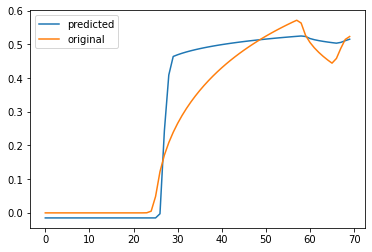

In [14]:
predict_single_point(cubic_map_data, 8)